# Diffusion of innovations
## Influence Maximization in the phonecalls network

Brianna Ayelen Balam Velasco

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from multiprocessing import Pool, cpu_count
import time

# Load the email network from the edge list
G = nx.read_edgelist('phonecalls.edgelist.txt', create_using=nx.DiGraph())

In [2]:
# Assigning a uniform activation probability to each edge
activation_probability = 0.1
for edge in G.edges():
    G[edge[0]][edge[1]]['probability'] = activation_probability

## Independent cascade model function

This function simulates the spread of influence through the network based on the independent cascade model

In [3]:
def independent_cascade(G, initial_active, steps=10):
    active = set(initial_active)
    new_active = active.copy()
    active_history = [set(active)]

    for _ in range(steps):
        current_new_active = set()
        for node in new_active:
            neighbors = G.successors(node)
            for neighbor in neighbors:
                if neighbor not in active and random.random() < G[node][neighbor]['probability']:
                    current_new_active.add(neighbor)

        new_active = current_new_active.difference(active)
        active.update(new_active)
        active_history.append(set(active))

    return active_history

## Simulartion functions

Functions to run the simulations and analyze the results

In [4]:
def run_simulation(args):
    G, seeds, steps = args
    active_history = independent_cascade(G, seeds, steps)
    return len(active_history[-1])

def run_simulations(G, seeds, iterations=10, steps=10):
    with Pool(cpu_count()) as pool:
        spread_results = pool.map(run_simulation, [(G, seeds, steps) for _ in range(iterations)])

    average_spread = sum(spread_results) / len(spread_results)
    return average_spread, spread_results

def degree_heuristic(G, k):
    degree_centrality = nx.degree_centrality(G)
    sorted_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
    return sorted_nodes[:k]

## Seed selction and execution simulation

Selecting seeds using the degree heuristic and running the influence maximization simulations

Selected seeds using degree heuristic: ['76', '494', '1179', '79', '1181']
Running simulation with 100 iterations...
Iterations: 100, Average Spread: 42.77, Std Dev: 15.20450919957629
Running simulation with 200 iterations...
Iterations: 200, Average Spread: 42.9, Std Dev: 13.990711204224038
Running simulation with 500 iterations...
Iterations: 500, Average Spread: 43.902, Std Dev: 14.57396294766801
Running simulation with 1000 iterations...
Iterations: 1000, Average Spread: 43.802, Std Dev: 15.04954471072132
Running simulation with 2000 iterations...
Iterations: 2000, Average Spread: 43.9245, Std Dev: 15.302346217165523


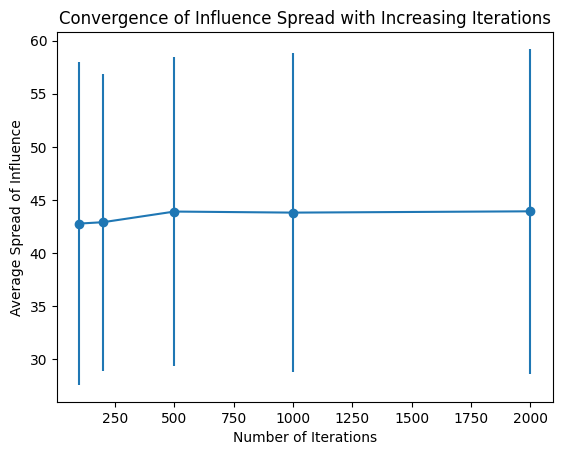

In [5]:
# Choose a number of seed nodes
num_seeds = 5
steps = 10
iterations_list = [100, 200, 500, 1000, 2000]  # test with different numbers of iterations

# Use a simpler heuristic method to find the most influential seeds
seed_nodes = degree_heuristic(G, num_seeds)
print(f"Selected seeds using degree heuristic: {seed_nodes}")

# Store the results for different numbers of iterations
results = []

for iters in iterations_list:
    print(f"Running simulation with {iters} iterations...")
    avg_spread, spread_results = run_simulations(G, seed_nodes, iterations=iters, steps=steps)
    results.append((iters, avg_spread, np.std(spread_results)))
    print(f"Iterations: {iters}, Average Spread: {avg_spread}, Std Dev: {np.std(spread_results)}")

# Plotting the results
iterations, avg_spreads, std_devs = zip(*results)
plt.errorbar(iterations, avg_spreads, yerr=std_devs, fmt='-o')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Spread of Influence')
plt.title('Convergence of Influence Spread with Increasing Iterations')
plt.show()

## Seed influence analysis

Analyzing how individual seeds contribute to the spread of influence

In [22]:
# Analyze the influence of individual seeds
def analyze_seed_influence(G, seeds, iterations=1500, steps=10):
    seed_spread = {}
    for seed in seeds:
        avg_spread, _ = run_simulations(G, [seed], iterations=iterations, steps=steps)
        seed_spread[seed] = avg_spread
    return seed_spread

seed_influence = analyze_seed_influence(G, seed_nodes, iterations=500, steps=steps)
print("Seed Influence Analysis:", seed_influence)

Seed Influence Analysis: {'76': 6.06, '494': 7.564, '1179': 21.934, '79': 1.806, '1181': 20.702}


## Visualization of active nodes over the time
Visualizing how the number of active nodes evolves over the time steps of the simulation

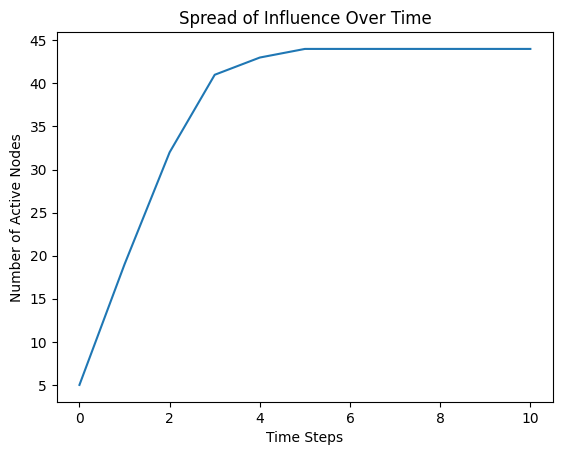

In [8]:
# Visualize the evolution of active nodes over time
simulation_result = independent_cascade(G, seed_nodes, steps=steps)
steps = len(simulation_result)
plt.plot(range(steps), [len(step) for step in simulation_result])
plt.title('Spread of Influence Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Number of Active Nodes')
plt.show()

## Histogram of Spread for 1500 iterations

Showing the distribution of the spread of influence across 1500 iterations

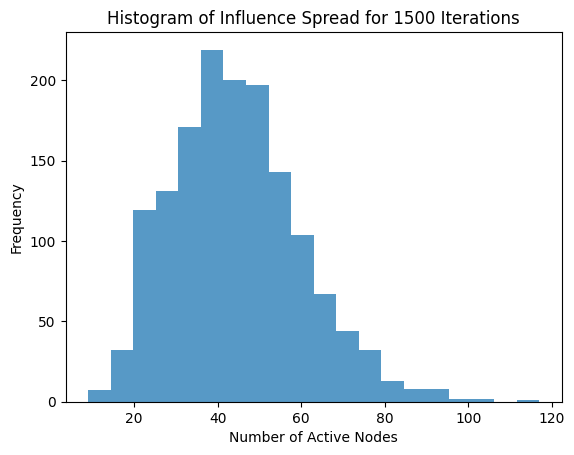

In [23]:
# Histogram of Spread for 1500 iterations
_, spread_results_1500 = run_simulations(G, seed_nodes, iterations=1500, steps=steps)
plt.hist(spread_results_1500, bins=20, alpha=0.75)
plt.title('Histogram of Influence Spread for 1500 Iterations')
plt.xlabel('Number of Active Nodes')
plt.ylabel('Frequency')
plt.show()

## Execution time analysis

Measuring and visualizing the execution time required for different numbers of iterations

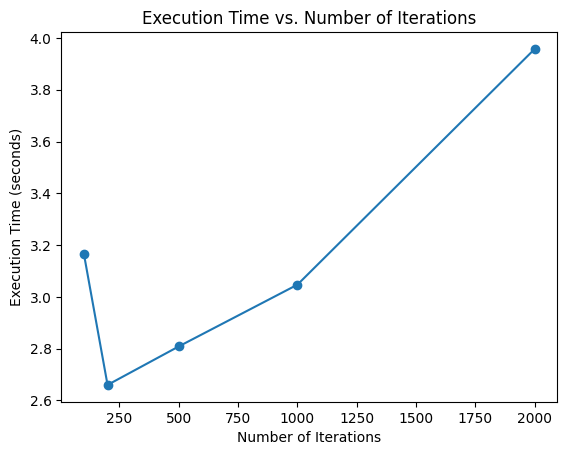

In [17]:
# Measure execution time
execution_times = []
for iters in iterations_list:
    start_time = time.time()
    run_simulations(G, seed_nodes, iterations=iters, steps=steps)
    end_time = time.time()
    execution_times.append(end_time - start_time)

plt.plot(iterations_list, execution_times, '-o')
plt.xlabel('Number of Iterations')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs. Number of Iterations')
plt.show()

## Degree distribution analysis

The degree distribution provides insights into the connectivity of the nodes within the network. A high frequency of low-degree nodes often indicates a sparse network, whereas a significant number of high-degree nodes might suggest the presence of hubs or highly connected regions

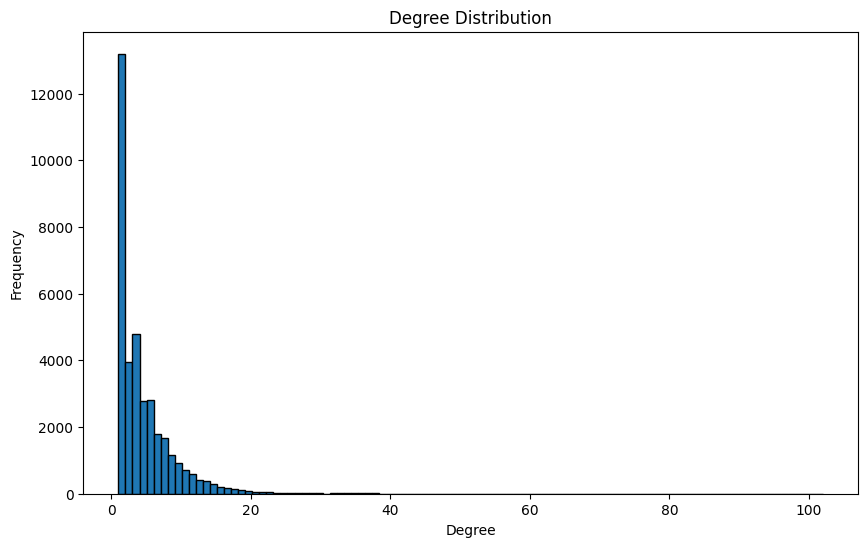

In [18]:
# Degree Distribution
degrees = [G.degree(n) for n in G.nodes()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=100, edgecolor='black')
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

## Clustering coefficient distribution analysis

The clustering coefficient measures the likelihood that two adjacent nodes of a given node are connected. High values generally indicate a tightly-knit community structure within the network

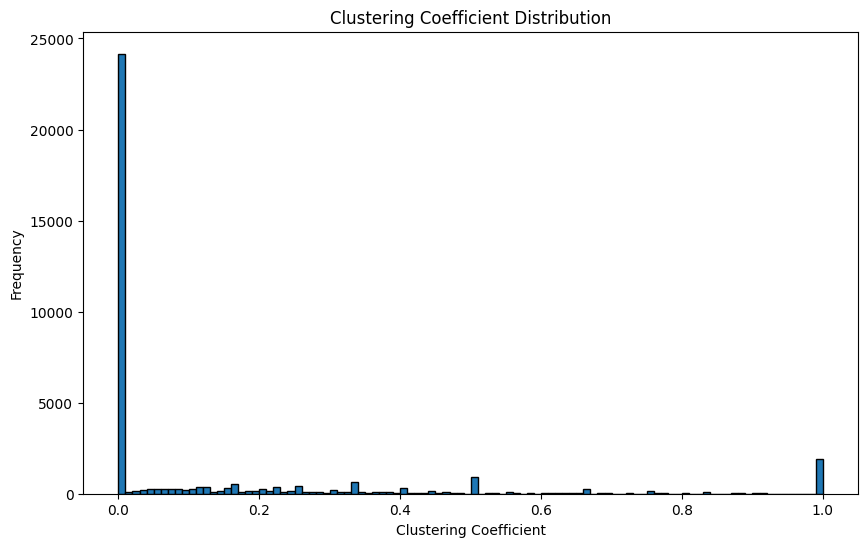

In [19]:
# Clustering Coefficient Distribution
clustering_coeffs = nx.clustering(G).values()
plt.figure(figsize=(10, 6))
plt.hist(clustering_coeffs, bins=100, edgecolor='black')
plt.title('Clustering Coefficient Distribution')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.show()

## Network component analysis

Analyzing the components of the network helps identify isolated subgraphs. The largest component can be especially telling of the network's overall connectivity.

In [24]:
# Analyze Components
components = list(nx.weakly_connected_components(G))
largest_component = max(components, key=len)
G_largest = G.subgraph(largest_component).copy()

print(f"Number of weakly connected components: {len(components)}")
print(f"Size of largest component: {len(largest_component)}")

Number of weakly connected components: 2463
Size of largest component: 30420


## Aditional network metrics

Understanding the overall density and clustering within the network can provide further insights into its structure.

In [25]:
# Additional logging for understanding the network properties
print("Network density:", nx.density(G))
print("Average clustering coefficient:", nx.average_clustering(G))

Network density: 6.856998135013894e-05
Average clustering coefficient: 0.13458747177926075
